In [ ]:
# Importy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import numpy as np

#  Wybór urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Urządzenie: {device}")

# Transformacje danych (Tiny ImageNet 64x64 + normalizacja ImageNet)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Ścieżki do danych
base_dir = '../tiny-imagenet-200'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Załaduj dane
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(val_dir, 'images'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Dane zostały pomyślnie wczytane.")


Urządzenie: cuda
Dane zostały pomyślnie wczytane.


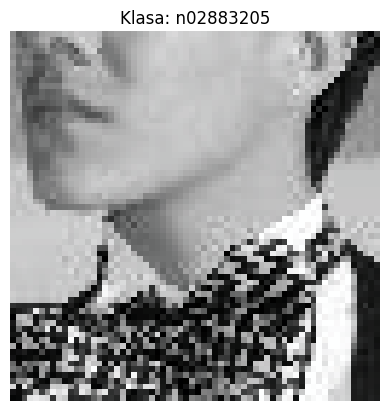

In [2]:
# Funkcja do losowego wyświetlenia obrazu
def show_random_image(data_loader, class_names):
    images, labels = next(iter(data_loader))
    idx = np.random.randint(0, len(images))
    image, label = images[idx], labels[idx]

    # Denormalizacja
    image = image.permute(1, 2, 0).numpy()
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(f'Klasa: {class_names[label]}')
    plt.axis('off')
    plt.show()

# Lista nazw klas
class_names = train_dataset.classes

# Podgląd
show_random_image(train_loader, class_names)


Definicja bazowego modelu (v1)
Na podstawie wcześniejszych eksperymentów z trzema typami architektur (BalancedCNN, OverfittingCNN, UnderfittingCNN) zaprojektowano model, który łączy najważniejsze cechy korzystnych konfiguracji: umiarkowaną głębokość, stabilizację treningu oraz mechanizmy regularyzujące. Jego zadaniem jest osiągnięcie możliwie wysokiej dokładności przy zachowaniu stabilności procesu uczenia i zdolności do generalizacji.

W niniejszej wersji bazowej zastosowano:

6 warstw konwolucyjnych z progresywną liczbą filtrów (64 → 128 → 256),

normalizację BatchNorm po każdej warstwie,

funkcję aktywacji ReLU,

warstwę MaxPool co kilka bloków konwolucyjnych,

Dropout w warstwach w pełni połączonych (dla redukcji przeuczenia),

strukturę FC zakończoną warstwą klasyfikacyjną dla 200 klas (Tiny ImageNet).

Model będzie w kolejnych etapach modyfikowany i dostrajany w oparciu o metryki walidacyjne.

In [3]:
import torch.nn as nn

class FinalModelV1(nn.Module):
    def __init__(self):
        super(FinalModelV1, self).__init__()

        self.features = nn.Sequential(
            # Blok 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Blok 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Blok 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 200)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


Konfiguracja treningu

In [4]:
import torch.optim as optim

model = FinalModelV1().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

num_epochs = 20


Pętla treningowa z walidacją i zapisem wyników

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

train_stats = []

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= total
    val_acc = correct / total

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    train_stats.append([epoch+1, train_loss, train_acc, val_loss, val_acc])

    # Zapisywanie najlepszego modelu
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "final_model_best_v1.pt")


Epoch 1/20 - Train Loss: 5.4093, Train Acc: 0.0048, Val Loss: 5.2882, Val Acc: 0.0000
Epoch 2/20 - Train Loss: 5.2993, Train Acc: 0.0045, Val Loss: 5.2915, Val Acc: 0.0000
Epoch 3/20 - Train Loss: 5.2991, Train Acc: 0.0044, Val Loss: 5.3020, Val Acc: 0.0000


KeyboardInterrupt: 

Zapis metryk do CSV

In [8]:
df = pd.DataFrame(train_stats, columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])
df.to_csv("training_results_final_model_v1.csv", index=False)


Rysowanie wykresu przebiegu treningu

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss")
plt.plot(df["Epoch"], df["Validation Loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df["Epoch"], df["Train Accuracy"], label="Train Accuracy")
plt.plot(df["Epoch"], df["Validation Accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.savefig("training_progress_final_model_v1.png")
plt.show()


Classification Report + Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load("final_model_best_v1.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Zapis classification_report
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
with open("classification_report_final_model_v1.txt", "w") as f:
    f.write(report)

# Macierz błędów
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix_final_model_v1.png")
plt.show()


 poniżej znajduje się kompaktowa wersja finalnego modelu (v2) oparta na najlepszych wynikach oraz rozszerzona o sprawdzone mechanizmy. W tym podejściu uwzględniono:

architekturę z progresywnym wzrostem liczby filtrów (64 → 128 → 256),

BatchNorm i Dropout,

optymalizator AdamW z weight decay,

harmonogram uczenia (scheduler),



In [ ]:
#Model, trening, walidacja, zapis metryk i wykresów
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# Konfiguracja
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformacje
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dane
base_dir = '../tiny-imagenet-200'
val_dir='../tiny-imagenet-200/val'
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(val_dir, 'images'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
class_names = train_dataset.classes

# Model
class FinalModelV2(nn.Module):
    def __init__(self):
        super(FinalModelV2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 200)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = FinalModelV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [ ]:
#trening i walidacja
num_epochs = 20
best_loss = float('inf')
stats = []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)
    train_loss /= total
    train_acc = train_correct / total

    model.eval()
    val_loss, val_correct = 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    val_loss /= len(val_dataset)
    val_acc = val_correct / len(val_dataset)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    stats.append([epoch+1, train_loss, train_acc, val_loss, val_acc])
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "final_model_best_v2.pt")

# Zapis wyników
df = pd.DataFrame(stats, columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
df.to_csv("training_results_final_model_v2.csv", index=False)

# Wykres
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss")
plt.plot(df["Epoch"], df["Val Loss"], label="Val Loss")
plt.plot(df["Epoch"], df["Train Accuracy"], label="Train Acc")
plt.plot(df["Epoch"], df["Val Accuracy"], label="Val Acc")
plt.xlabel("Epoch"); plt.legend(); plt.tight_layout()
plt.savefig("training_progress_final_model.png"); plt.show()

# Raport
model.load_state_dict(torch.load("final_model_best_v2.pt"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
with open("classification_report_final_model_v2.txt", "w") as f:
    f.write(report)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_final_model_v2.png")
plt.show()


Epoch 1/20 | Train Acc: 0.0060 | Val Acc: 0.0000
Epoch 2/20 | Train Acc: 0.0073 | Val Acc: 0.0000


KeyboardInterrupt: 

Co zawiera FinalModelV3:
Głębszą architekturę (8 warstw konwolucyjnych) z przemyślanym podziałem bloków,

Batch Normalization i ReLU w każdym bloku,

Dropout w warstwach w pełni połączonych i na wyjściu bloku konwolucyjnego,

Optymalizator AdamW z harmonogramem CosineAnnealingLR,

EarlyStopping na podstawie walidacyjnego lossu (patience=5),

20% augmentacji danych (obrót, losowe przycięcie),

Dokładne logowanie: zapisywanie strat, dokładności, wykresów, raportu klasyfikacji, macierzy błędów.

In [14]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base = '../tiny-imagenet-200'
train_ds = datasets.ImageFolder(os.path.join(base, 'train'), transform=transform_train)
val_ds = datasets.ImageFolder(os.path.join(base, 'val'), transform=transform_val)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
class_names = train_ds.classes

class FinalModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        def conv_block(in_c, out_c): return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU())
        self.features = nn.Sequential(
            conv_block(3, 64), conv_block(64, 64), nn.MaxPool2d(2),
            conv_block(64, 128), conv_block(128, 128), nn.MaxPool2d(2),
            conv_block(128, 256), conv_block(256, 256), nn.Dropout(0.2), nn.MaxPool2d(2),
            conv_block(256, 512), conv_block(512, 512), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 200)
        )
    def forward(self, x): return self.classifier(self.features(x))

model = FinalModelV3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
early_patience = 5
best_loss = float('inf')
early_counter = 0
log = []


In [15]:
epochs = 50
for epoch in range(epochs):
    model.train()
    tr_loss, tr_correct, total = 0, 0, 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * x.size(0)
        tr_correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    tr_loss /= total
    tr_acc = tr_correct / total

    model.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    val_loss /= len(val_ds)
    val_acc = val_correct / len(val_ds)
    scheduler.step()

    log.append([epoch+1, tr_loss, tr_acc, val_loss, val_acc])
    print(f"Ep {epoch+1}: Train {tr_acc:.3f}, Val {val_acc:.3f}, Val Loss {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "final_model_v3_best.pt")
        early_counter = 0
    else:
        early_counter += 1
        if early_counter >= early_patience:
            print("Early stopping")
            break

# Metryki
df = pd.DataFrame(log, columns=["Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc"])
df.to_csv("training_results_final_model_v3.csv", index=False)
plt.plot(df["Epoch"], df["Train Acc"], label="Train Acc")
plt.plot(df["Epoch"], df["Val Acc"], label="Val Acc")
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss")
plt.plot(df["Epoch"], df["Val Loss"], label="Val Loss")
plt.legend(); plt.grid(); plt.savefig("training_progress_final_model_v3.png"); plt.show()

# Raport + macierz
model.load_state_dict(torch.load("final_model_v3_best.pt"))
model.eval(); all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
with open("classification_report_final_model_v3.txt", "w") as f: f.write(report)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_final_model_v3.png")
plt.show()


Ep 1: Train 0.012, Val 0.018, Val Loss 6.0650
Ep 2: Train 0.020, Val 0.003, Val Loss 6.9510
Ep 3: Train 0.039, Val 0.001, Val Loss 8.6990


KeyboardInterrupt: 

nowoczesny model CNN, który poradzi sobie z Tiny ImageNet – małym, ale wymagającym zbiorem. Użyjemy:

Residual blocks (ResNet-style),

Batch Normalization,

Dropout,

Global Average Pooling,

Data augmentation (już masz, skoro używasz ImageFolder + transformacje),

Oraz AdamW jako optymalizatora.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

# Final CNN model
class CNNv2(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.stage1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )
        self.stage2 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128)
        )
        self.stage3 = nn.Sequential(
            ResidualBlock(128, 256, downsample=True),
            ResidualBlock(256, 256)
        )
        self.stage4 = nn.Sequential(
            ResidualBlock(256, 512, downsample=True),
            ResidualBlock(512, 512)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [ ]:
# Test model on validation set
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Validation Accuracy: {acc:.2f}%")
    return acc

# Przykład użycia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNv2(num_classes=200).to(device)
evaluate(model, val_loader, device)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# Parametry treningu
num_epochs = 50
learning_rate = 0.001
weight_decay = 1e-4

# Przygotowanie modelu, optymalizatora i scheduler'a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNv2(num_classes=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Funkcja treningowa
def train(model, train_loader, val_loader):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        val_acc = evaluate(model, val_loader, device)
        scheduler.step()

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

        # Zapis najlepszego modelu
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    print(f"Najlepsza dokładność walidacyjna: {best_acc:.2f}%")

# Wywołanie treningu
train(model, train_loader, val_loader)
